In [1]:
pip install qiskit.ignis

^C
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/pip/__main__.py", line 21, in <module>
    from pip._internal.cli.main import main as _main
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 8, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/cmdoptions.py", line 22, in <module>
    from pip._internal.cli.pr

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, assemble, transpile, Aer, IBMQ
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *
# from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy
from qiskit import execute

from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit import QuantumRegister
from qiskit.visualization import array_to_latex

# Loading your IBM Quantum account(s)

/tmp/ipykernel_1496/83197244.py:14: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# provider = IBMQ.get_provider(hub='ibm')
real_backend = least_busy(provider.backends(filters=lambda x: not x.configuration().simulator))
# real_backend = provider.get_backend('ibm_lagos')
print("backend used: ", real_backend)

backend used:  ibmq_manila


In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    oracle_qc.name = "oracle " + case
    return oracle_qc
    # oracle_gate = oracle_qc.to_gate()
    # oracle_gate.name = "Oracle" # To show when we display the circuit
    # return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    # dj_circuit.barrier()
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    # dj_circuit.barrier()
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
aer_sim = Aer.get_backend('aer_simulator')

In [6]:
n = 3

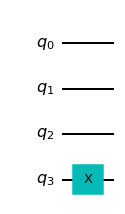

In [7]:
oracle_qc = dj_oracle('constant', n)
oracle_qc.draw()

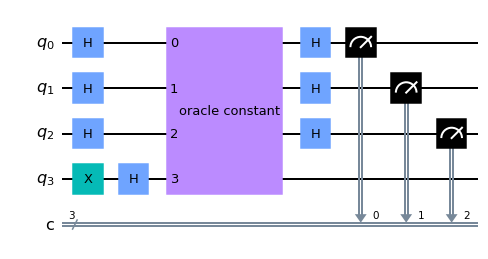

In [8]:
dj_circuit = dj_algorithm(oracle_qc, n)
dj_circuit.draw()

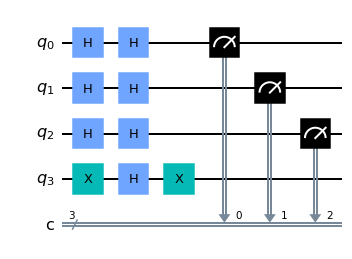

In [9]:
new_dj = dj_circuit.decompose('oracle constant')

new_dj.draw()

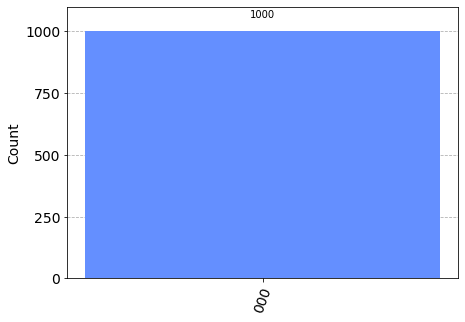

In [11]:
aer_backend = Aer.get_backend('aer_simulator')
aer_job = execute(dj_circuit, aer_backend, shots=1000)
aer_results = aer_job.result()
aer_counts = aer_results.get_counts()
plot_histogram(aer_counts)

In [10]:
job = execute(dj_circuit, real_backend, shots=1000)
realqc_results = job.result()

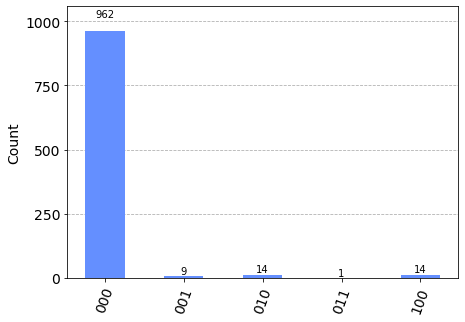

In [11]:
counts = realqc_results.get_counts()
plot_histogram(counts)

In [12]:
# QEM
qr = QuantumRegister(n)
qem_meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
qem_cal_results = real_backend.run(qem_meas_calibs, shots=10000).result()

In [13]:
meas_fitter = CompleteMeasFitter(qem_cal_results, state_labels, circlabel='mcal')
array_to_latex(meas_fitter.cal_matrix)

<IPython.core.display.Latex object>

In [ ]:
# cal_results = aer_simulator.run(qem_meas_calibs, shots=10000).result()
# meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# array_to_latex(meas_fitter.cal_matrix)

In [14]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(realqc_results)
mitigated_counts = mitigated_results.get_counts()

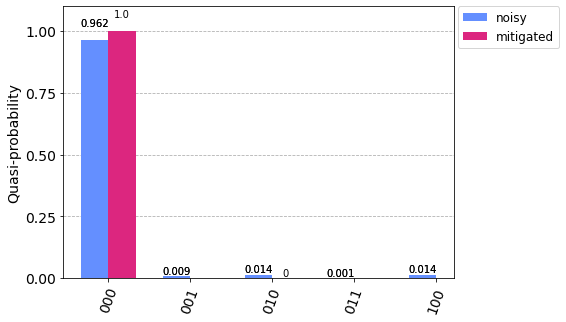

In [15]:
noisy_counts = realqc_results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [16]:
# GEM
# not calibrating ancilla
# depends on the concrete DJ circuit
dj_left0 = QuantumCircuit(n,n)
dj_left1 = QuantumCircuit(n) 
dj_left2 = QuantumCircuit(n)
dj_left3 = QuantumCircuit(n)
dj_left4 = QuantumCircuit(n)
dj_left5 = QuantumCircuit(n)
dj_left6 = QuantumCircuit(n)
dj_left7 = QuantumCircuit(n)

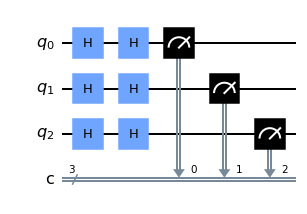

In [17]:
dj_left0.h(0)

dj_left0.h(0)

dj_left0.h(1)
dj_left0.h(1)
dj_left0.h(2)
dj_left0.h(2)
dj_left0.measure([0,1,2], [0,1,2])
dj_left0.draw()

/tmp/ipykernel_1496/4218642948.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left1 += dj_left0


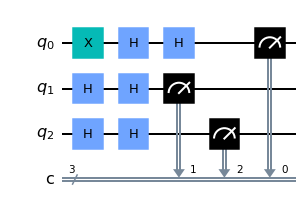

In [18]:
dj_left1.x(0)
dj_left1 += dj_left0
dj_left1.draw()

/tmp/ipykernel_1496/2252380090.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left2 += dj_left0


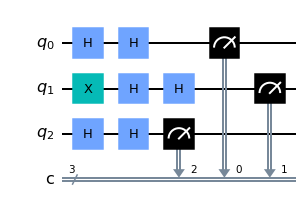

In [19]:
dj_left2.x(1)
dj_left2 += dj_left0
dj_left2.draw()

/tmp/ipykernel_1496/810308772.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left3 += dj_left0


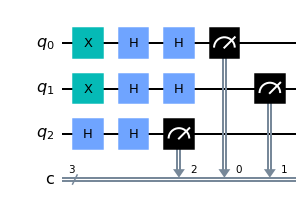

In [20]:
dj_left3.x(0)
dj_left3.x(1)
dj_left3 += dj_left0
dj_left3.draw()

/tmp/ipykernel_1496/264572622.py:2: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left4 += dj_left0


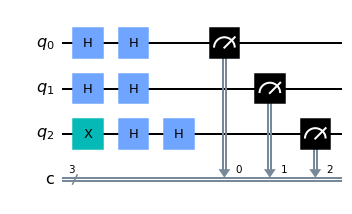

In [21]:
dj_left4.x(2)
dj_left4 += dj_left0
dj_left4.draw()

/tmp/ipykernel_1496/2497025790.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left5 += dj_left0


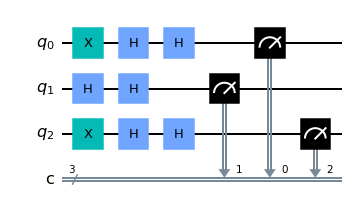

In [22]:
dj_left5.x(2)
dj_left5.x(0)
dj_left5 += dj_left0
dj_left5.draw()

/tmp/ipykernel_1496/2426855407.py:3: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left6 += dj_left0


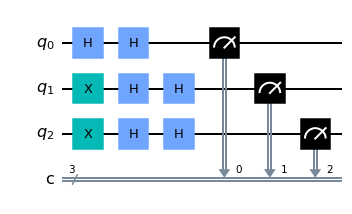

In [23]:
dj_left6.x(2)
dj_left6.x(1)
dj_left6 += dj_left0
dj_left6.draw()

/tmp/ipykernel_1496/778788731.py:4: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_left7 += dj_left0


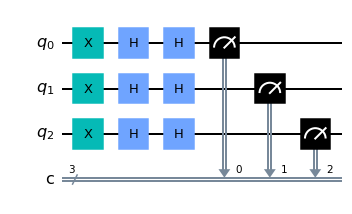

In [24]:
dj_left7.x(2)
dj_left7.x(1)
dj_left7.x(0)
dj_left7 += dj_left0
dj_left7.draw()

In [25]:
meas_calibs = [dj_left0, dj_left1, dj_left2, dj_left3, dj_left4, dj_left5, dj_left6, dj_left7]
print(len(meas_calibs))

8


In [ ]:
# for circuit in meas_calibs:
#     print('Circuit',circuit.name)
#     print(circuit)

In [ ]:
# t_qc = transpile(meas_calibs, aer_sim)
# qobj = assemble(t_qc, shots=10000)
# results = aer_sim.run(qobj, shots=10000).result()
# result_counts = results.get_counts()
# print(result_counts)

In [26]:
t_qc = transpile(meas_calibs, real_backend)
qobj = assemble(t_qc, shots=10000)
real_results = real_backend.run(qobj, shots=10000).result()

/tmp/ipykernel_1496/1499486007.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  real_results = real_backend.run(qobj, shots=10000).result()


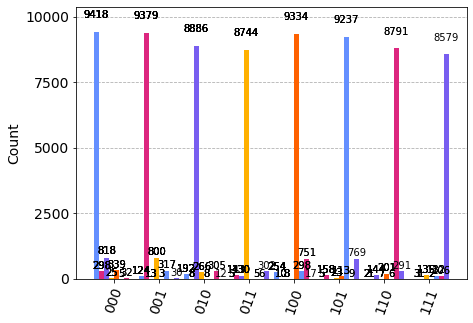

In [27]:
real_counts = real_results.get_counts()
plot_histogram(real_counts)

In [28]:
ls = []
for qc in meas_calibs:
     counts = real_results.get_counts(qc)
     this_array = np.array([counts.get('000') or 0, counts.get('001') or 0, counts.get('010') or 0, counts.get('011') or 0 , counts.get('100') or 0, counts.get('101') or 0, counts.get('110') or 0, counts.get('111') or 0])
     this_array = this_array/10000
     ls.append(this_array)
     print(this_array)
     
array = np.array(ls)
# print(array)
array_t = np.transpose(array)
print(array_t)

[9.418e-01 1.240e-02 1.920e-02 5.000e-04 2.540e-02 5.000e-04 2.000e-04
 0.000e+00]
[2.980e-02 9.379e-01 8.000e-04 1.430e-02 1.000e-03 1.580e-02 1.000e-04
 3.000e-04]
[8.180e-02 1.300e-03 8.886e-01 1.300e-02 8.000e-04 0.000e+00 1.440e-02
 1.000e-04]
[2.500e-03 8.000e-02 2.660e-02 8.744e-01 0.000e+00 2.300e-03 7.000e-04
 1.350e-02]
[3.390e-02 3.000e-04 8.000e-04 0.000e+00 9.334e-01 1.130e-02 2.010e-02
 2.000e-04]
[5.000e-04 3.170e-02 0.000e+00 5.000e-04 2.980e-02 9.237e-01 6.000e-04
 1.320e-02]
[3.200e-03 0.000e+00 3.050e-02 6.000e-04 7.510e-02 9.000e-04 8.791e-01
 1.060e-02]
[0.     0.003  0.0012 0.0302 0.0017 0.0769 0.0291 0.8579]
[[9.418e-01 2.980e-02 8.180e-02 2.500e-03 3.390e-02 5.000e-04 3.200e-03
  0.000e+00]
 [1.240e-02 9.379e-01 1.300e-03 8.000e-02 3.000e-04 3.170e-02 0.000e+00
  3.000e-03]
 [1.920e-02 8.000e-04 8.886e-01 2.660e-02 8.000e-04 0.000e+00 3.050e-02
  1.200e-03]
 [5.000e-04 1.430e-02 1.300e-02 8.744e-01 0.000e+00 5.000e-04 6.000e-04
  3.020e-02]
 [2.540e-02 1.000e-03

In [29]:
array_to_latex(array)

<IPython.core.display.Latex object>

In [30]:
import scipy.linalg as la
array_inv = la.inv(array_t)
array_to_latex(array_inv)

<IPython.core.display.Latex object>

In [31]:
counts = realqc_results.get_counts()

In [32]:
result_array = np.array([counts.get('000') or 0, counts.get('001') or 0, counts.get('010') or 0, counts.get('011') or 0 , counts.get('100') or 0, counts.get('101') or 0, counts.get('110') or 0, counts.get('111') or 0])
result_array = result_array/1000

In [33]:
result_array

array([0.962, 0.009, 0.014, 0.001, 0.014, 0.   , 0.   , 0.   ])

In [34]:
mitigated = np.dot(array_inv, result_array)

In [35]:
array_to_latex(mitigated)

<IPython.core.display.Latex object>

In [36]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
normal = NormalizeData(mitigated)

In [38]:
array_to_latex(normal)

<IPython.core.display.Latex object>

In [39]:
def Normalize(arr):
    return arr/sum(arr)

In [40]:
new_normal = Normalize(mitigated)

In [41]:
array_to_latex(new_normal)

<IPython.core.display.Latex object>